In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")
data_dir = "./data"

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101
Using the GPU!


In [ ]:
# !pip3 install face_recognition
# !unzip /content/data.zip
!unzip /content/deepfake.zip

In [ ]:
!pip3 install split-folders



In [ ]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("deepfake", output="data", seed=1337, ratio=(.25, .5, .25), group_prefix=None) # default values

Copying files: 5405 files [00:01, 4551.34 files/s]


In [ ]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    '''
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.

    '''

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #  

    # ========= Step 1: build transformations for the dataset ===========
    # You need to construct build a data transformation that does three preprocessings in order:
    # I.   Resize the image to input_size using transforms.Resize
    # II.  Convert the image to PyTorch tensor using transforms.ToTensor
    # III. Normalize the images with the provided mean and std parameters using transforms.Normalize. These parameters are accumulated from a large number of training samples.
    # You can use transforms.Compose to combine the above three transformations. Store the combined transforms in variable 'composed_transform'.
    composed_transform = transforms.Compose(
    [transforms.Resize((256,265)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    # We write the remaining part of the dataloader for you.  
    # You are encouraged to go through this.

    # ========= Step 2: We build dataloaders for the downloaded data ===========
    # I.   We use torch.datasets.ImageFolder with the provided data_dir and the data transfomations you created in step 1 to contruct pytorch datasets for train/val/test 
    # II.  Then we use torch.utils.data.DataLoader to build dataloaders with the constructed pytorch datasets, you need to enable shuffling for training set. Set num_workers=2 to speed up dataloading.
    # III. Finally, we put the dataloaders into a dictionary

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}
    


    return dataloaders_dict

In [ ]:
batch_size = 32
input_size = 256
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 1350
# of validation samples 2702
# of test samples 1353


In [ ]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    '''

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [ ]:
# Network configurations for all layers before the final fully-connected layers. 
# "M" corresponds to maxpooling layer, integers correspond to number of output channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):

    '''
    Return a nn.Sequential object containing all layers to get the features using the CNN.
    (That is, before the Average pooling layer in the two pictures above). 

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction layers. For use of torch.nn.Sequential, please refer to PyTorch documents.
    '''
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    layers = []
    temp = 3
    for layer in cfg:
      if layer == 'M':
        layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding = 0, dilation = 1, ceil_mode = False)]
      else:
        convolved = nn.Conv2d(temp, layer, kernel_size=(3, 3), stride = (1, 1), padding=(1, 1))
        temp = layer
        if batch_norm:
          layers+=([convolved, nn.BatchNorm2d(temp), nn.ReLU(inplace=True)])
        else:
          layers+=([convolved, nn.ReLU(inplace=True)])
    return nn.Sequential(*layers)

    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

         
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== #
        # Construct the final FC layers using nn.Sequential.
        # NOTE: The avgpool layer has already been defined by us above.
         
        self.classifier = nn.Sequential(
            nn.Linear(in_features = 3200,out_features = 512,bias= True),
            nn.ReLU(True),
            nn.Dropout(p=0.5, inplace = False),
            nn.Linear(in_features = 512,out_features = 256,bias= True),
            nn.ReLU(True),
            nn.Dropout(p=0.5, inplace = False),
            nn.Linear(in_features = 256,out_features = 100,bias= True),
        )
        
        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

        if init_weights:
            self._initialize_weights()

    def forward(self, x): 
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

MESO4 Network


In [ ]:
class Meso4(nn.Module):
	"""
	Pytorch Implemention of Meso4
	Autor: Honggu Liu
	Date: July 4, 2019
	"""
	def __init__(self, num_classes=2):
		super(Meso4, self).__init__()
		self.num_classes = num_classes
		self.conv1 = nn.Conv2d(3, 8, 3, padding=1, bias=False)
		self.bn1 = nn.BatchNorm2d(8)
		self.relu = nn.ReLU(inplace=True)
		self.leakyrelu = nn.LeakyReLU(0.1)

		self.conv2 = nn.Conv2d(8, 8, 5, padding=2, bias=False)
		self.bn2 = nn.BatchNorm2d(16)
		self.conv3 = nn.Conv2d(8, 16, 5, padding=2, bias=False)
		self.conv4 = nn.Conv2d(16, 16, 5, padding=2, bias=False)
		self.maxpooling1 = nn.MaxPool2d(kernel_size=(2, 2))
		self.maxpooling2 = nn.MaxPool2d(kernel_size=(4, 4))
		#flatten: x = x.view(x.size(0), -1)
		self.dropout = nn.Dropout2d(0.5)
		self.fc1 = nn.Linear(16*8*8, 16)
		self.fc2 = nn.Linear(16, num_classes)

	def forward(self, input):
		x = self.conv1(input) #(8, 256, 256)
		x = self.relu(x)
		x = self.bn1(x)
		x = self.maxpooling1(x) #(8, 128, 128)

		x = self.conv2(x) #(8, 128, 128)
		x = self.relu(x)
		x = self.bn1(x)
		x = self.maxpooling1(x) #(8, 64, 64)

		x = self.conv3(x) #(16, 64, 64)
		x = self.relu(x)
		x = self.bn2(x)
		x = self.maxpooling1(x) #(16, 32, 32)

		x = self.conv4(x) #(16, 32, 32)
		x = self.relu(x)
		x = self.bn2(x)
		x = self.maxpooling2(x) #(16, 8, 8)

		x = x.view(x.size(0), -1) #(Batch, 16*8*8)
		x = self.dropout(x)
		x = self.fc1(x) #(Batch, 16)
		x = self.leakyrelu(x)
		x = self.dropout(x)
		x = self.fc2(x)

		return x


class MesoInception4(nn.Module):
	"""
	Pytorch Implemention of MesoInception4
	Author: Honggu Liu
	Date: July 7, 2019
	"""
	def __init__(self, num_classes=2):
		super(MesoInception4, self).__init__()
		self.num_classes = num_classes
		#InceptionLayer1
		self.Incption1_conv1 = nn.Conv2d(3, 1, 1, padding=0, bias=False)
		self.Incption1_conv2_1 = nn.Conv2d(3, 4, 1, padding=0, bias=False)
		self.Incption1_conv2_2 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
		self.Incption1_conv3_1 = nn.Conv2d(3, 4, 1, padding=0, bias=False)
		self.Incption1_conv3_2 = nn.Conv2d(4, 4, 3, padding=2, dilation=2, bias=False)
		self.Incption1_conv4_1 = nn.Conv2d(3, 2, 1, padding=0, bias=False)
		self.Incption1_conv4_2 = nn.Conv2d(2, 2, 3, padding=3, dilation=3, bias=False)
		self.Incption1_bn = nn.BatchNorm2d(11)


		#InceptionLayer2
		self.Incption2_conv1 = nn.Conv2d(11, 2, 1, padding=0, bias=False)
		self.Incption2_conv2_1 = nn.Conv2d(11, 4, 1, padding=0, bias=False)
		self.Incption2_conv2_2 = nn.Conv2d(4, 4, 3, padding=1, bias=False)
		self.Incption2_conv3_1 = nn.Conv2d(11, 4, 1, padding=0, bias=False)
		self.Incption2_conv3_2 = nn.Conv2d(4, 4, 3, padding=2, dilation=2, bias=False)
		self.Incption2_conv4_1 = nn.Conv2d(11, 2, 1, padding=0, bias=False)
		self.Incption2_conv4_2 = nn.Conv2d(2, 2, 3, padding=3, dilation=3, bias=False)
		self.Incption2_bn = nn.BatchNorm2d(12)

		#Normal Layer
		self.conv1 = nn.Conv2d(12, 16, 5, padding=2, bias=False)
		self.relu = nn.ReLU(inplace=True)
		self.leakyrelu = nn.LeakyReLU(0.1)
		self.bn1 = nn.BatchNorm2d(16)
		self.maxpooling1 = nn.MaxPool2d(kernel_size=(2, 2))

		self.conv2 = nn.Conv2d(16, 16, 5, padding=2, bias=False)
		self.maxpooling2 = nn.MaxPool2d(kernel_size=(4, 4))

		self.dropout = nn.Dropout2d(0.5)
		self.fc1 = nn.Linear(16*8*8, 16)
		self.fc2 = nn.Linear(16, num_classes)


	#InceptionLayer
	def InceptionLayer1(self, input):
		x1 = self.Incption1_conv1(input)
		x2 = self.Incption1_conv2_1(input)
		x2 = self.Incption1_conv2_2(x2)
		x3 = self.Incption1_conv3_1(input)
		x3 = self.Incption1_conv3_2(x3)
		x4 = self.Incption1_conv4_1(input)
		x4 = self.Incption1_conv4_2(x4)
		y = torch.cat((x1, x2, x3, x4), 1)
		y = self.Incption1_bn(y)
		y = self.maxpooling1(y)

		return y

	def InceptionLayer2(self, input):
		x1 = self.Incption2_conv1(input)
		x2 = self.Incption2_conv2_1(input)
		x2 = self.Incption2_conv2_2(x2)
		x3 = self.Incption2_conv3_1(input)
		x3 = self.Incption2_conv3_2(x3)
		x4 = self.Incption2_conv4_1(input)
		x4 = self.Incption2_conv4_2(x4)
		y = torch.cat((x1, x2, x3, x4), 1)
		y = self.Incption2_bn(y)
		y = self.maxpooling1(y)

		return y

	def forward(self, input):
		x = self.InceptionLayer1(input) #(Batch, 11, 128, 128)
		x = self.InceptionLayer2(x) #(Batch, 12, 64, 64)

		x = self.conv1(x) #(Batch, 16, 64 ,64)
		x = self.relu(x)
		x = self.bn1(x)
		x = self.maxpooling1(x) #(Batch, 16, 32, 32)

		x = self.conv2(x) #(Batch, 16, 32, 32)
		x = self.relu(x)
		x = self.bn1(x)
		x = self.maxpooling2(x) #(Batch, 16, 8, 8)

		x = x.view(x.size(0), -1) #(Batch, 16*8*8)
		x = self.dropout(x)
		x = self.fc1(x) #(Batch, 16)
		x = self.leakyrelu(x)
		x = self.dropout(x)
		x = self.fc2(x)

		return x

Xception net

In [ ]:
""" 
Creates an Xception Model as defined in:
Francois Chollet
Xception: Deep Learning with Depthwise Separable Convolutions
https://arxiv.org/pdf/1610.02357.pdf
This weights ported from the Keras implementation. Achieves the following performance on the validation set:
Loss:0.9173 Prec@1:78.892 Prec@5:94.292
REMEMBER to set your image size to 3x299x299 for both test and validation
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])
The resize parameter of the validation transform should be 333, and make sure to center crop at 299x299
"""
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init
import torch

__all__ = ['xception']

model_urls = {
    'xception':'https://www.dropbox.com/s/1hplpzet9d7dv29/xception-c0a72b38.pth.tar?dl=1'
}


class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x



class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()

        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)



        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------





    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



def xception(pretrained=False,**kwargs):
    """
    Construct Xception.
    """

    model = Xception(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['xception']))
    return model

In [ ]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

meso4 = Meso4()
meso4I = MesoInception4()

xcept = Xception()

print(meso4)
print('Number of trainable parameters {}'.format(count_params(meso4)))

print(meso4I)
print('Number of trainable parameters {}'.format(count_params(meso4I)))

print(xcept)
print('Number of trainable parameters {}'.format(count_params(xcept)))

# Print the network architectrue. Please compare the printed architecture with the one given in the instruction above. 
# Make sure your network has the same architecture as the one we give above.
# print(vgg)
# print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

Meso4(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (conv2): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (maxpooling1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (maxpooling2): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)
Number of trainable

In [ ]:
def make_optimizer(model):
  '''Args:model: NN to trainReturns:optimizer: pytorch optmizer for updating the given model parameters.'''
  #++++++++++++++++++++++++++++++++++++++++++++++#
  #++++++++++++++++++++++++++++++++++++++++++++++#
  # ============== YOUR CODE HERE ============== #
  # Create a SGD optimizer with a learning rate 1e-2, momentum = 0.9
  # HINT:
  # We have imported torch.optim as optim for you
  # Checkout optim.SGD() and initialize with appropriate parameters
  params_to_update=model.parameters()
  optimizer = optim.Adam(params_to_update, lr=1e-3, betas=(0.9, 0.999), eps=1e-08)
  # optimizer=optim.SGD(params_to_update, lr=1e-1, momentum=0.9)
  # ============== END OF CODE ================= #
  #++++++++++++++++++++++++++++++++++++++++++++++#
  #++++++++++++++++++++++++++++++++++++++++++++++#
  return optimizer

def get_loss():
  criterion=nn.CrossEntropyLoss()
  return criterion

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    '''
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    '''

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 
                # ============== YOUR CODE HERE ============== #
#def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                  # Get model outputs and calculate loss
                  outputs=model(inputs)
                  loss=criterion(outputs, labels)
                  # torch.max outputs the maximum value, and its index
                  # Since the input is batched, we take the max along axis 1
                  # (the meaningful outputs)
                  _, preds=torch.max(outputs,1)
                  # backprop + optimize only if in training phase
                  if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Please read all the inputs carefully!
                # For "train" phase: 
                # (i)   Compute the outputs using model
                #       Also, use outputs to calculate predicted class by model,
                #       Store the predicted class in variable 'preds'
                #       (Think argmax of outputs across a dimension)
                #       torch.max() might help!
                # (ii)  Calculate the loss using criterion. Store it as 'loss' 
                # (iii) Update the model parameters

                # Don't forget to zero the gradients for each iteration!
                
                # For "val" phase, same as train but without backprop 
                # Compute the outputs (Same as "train", calculate 'preds' also), 
                # Calculate the loss, store it as 'loss'


                # ============== END OF CODE ================= # 
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # ================================ IMPORTANT ===============================================
                # Lossing connection to colab will lead to loss of trained weights.
                # You can download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to train the neural networks again.
                # ==========================================================================================
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

In [ ]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 2

# Batch size for training 
batch_size = 32

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloders and criterion function
input_size = 64 # do not change this
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [ ]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
features2 = make_layers(cfgs['MiniVGG'], batch_norm=False)
modelvgg = VGG(features2).to(device)
model = VGG(features).to(device)
model2 = meso4.to(device)
model3 = meso4I.to(device)
optimizervgg = make_optimizer(modelvgg)
optimizer = make_optimizer(model)
optimizer2 = make_optimizer(model2)
optimizer3 = make_optimizer(model3)

# vgg, tr_his, val_his = train_model(model=modelvgg, dataloaders=dataloaders, criterion=get_loss(), optimizer=optimizervgg,
#            save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

# vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=get_loss(), optimizer=optimizer,
#            save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

meso, tr_his_meso, val_his_meso = train_model(model=model2, dataloaders=dataloaders, criterion=get_loss(), optimizer=optimizer2,
           save_dir=save_dir, num_epochs=num_epochs, model_name='Meso4')

mesoI, tr_his_mesoI, val_his_mesoI = train_model(model=model3, dataloaders=dataloaders, criterion=get_loss(), optimizer=optimizer3,
           save_dir=save_dir, num_epochs=num_epochs, model_name='Meso4I')

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.7198 Acc: 0.5348


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.6900 Acc: 0.5192
Epoch 1/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.6875 Acc: 0.5459


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.6809 Acc: 0.5540
Epoch 2/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.6571 Acc: 0.6037


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.6637 Acc: 0.5888
Epoch 3/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.5878 Acc: 0.6615


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.7477 Acc: 0.5000
Epoch 4/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.5277 Acc: 0.7452


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.9989 Acc: 0.5329
Epoch 5/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.4896 Acc: 0.7719


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.7678 Acc: 0.5477
Epoch 6/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.4312 Acc: 0.8067


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.8146 Acc: 0.5688
Epoch 7/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.4372 Acc: 0.7881


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.7763 Acc: 0.5640
Epoch 8/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.3730 Acc: 0.8267


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.7076 Acc: 0.6436
Epoch 9/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.3708 Acc: 0.8259


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5580 Acc: 0.7184
Epoch 10/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.3401 Acc: 0.8489


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.8218 Acc: 0.6051
Epoch 11/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.3596 Acc: 0.8341


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5601 Acc: 0.6965
Epoch 12/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.3173 Acc: 0.8644


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.6826 Acc: 0.6136
Epoch 13/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.2874 Acc: 0.8719


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5147 Acc: 0.6776
Epoch 14/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.2562 Acc: 0.8911


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4308 Acc: 0.8294
Epoch 15/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.2274 Acc: 0.8985


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4874 Acc: 0.7465
Epoch 16/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.2232 Acc: 0.9074


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 1.0505 Acc: 0.5563
Epoch 17/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.2066 Acc: 0.9111


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5970 Acc: 0.7117
Epoch 18/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.1857 Acc: 0.9244


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5040 Acc: 0.7246
Epoch 19/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.1732 Acc: 0.9215


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.3965 Acc: 0.8164
Best val Acc: 0.829386
Epoch 0/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.7045 Acc: 0.5600


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.7192 Acc: 0.5196
Epoch 1/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.6354 Acc: 0.6585


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5764 Acc: 0.7169
Epoch 2/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.5514 Acc: 0.7304


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5169 Acc: 0.7309
Epoch 3/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.4718 Acc: 0.7763


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4369 Acc: 0.7976
Epoch 4/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.4391 Acc: 0.8007


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4369 Acc: 0.7972
Epoch 5/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.3819 Acc: 0.8326


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4701 Acc: 0.7717
Epoch 6/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.3413 Acc: 0.8504


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4593 Acc: 0.7865
Epoch 7/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.2884 Acc: 0.8815


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4504 Acc: 0.7927
Epoch 8/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.2286 Acc: 0.8985


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.4874 Acc: 0.7798
Epoch 9/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.1477 Acc: 0.9407


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 1.1336 Acc: 0.6643
Epoch 10/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.2546 Acc: 0.9059


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5846 Acc: 0.7539
Epoch 11/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.1516 Acc: 0.9363


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.9312 Acc: 0.6514
Epoch 12/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.1435 Acc: 0.9341


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 1.7260 Acc: 0.5699
Epoch 13/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.1439 Acc: 0.9363


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 0.5122 Acc: 0.8253
Epoch 14/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.1556 Acc: 0.9452


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 1.0620 Acc: 0.6799
Epoch 15/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.1274 Acc: 0.9533


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 1.7517 Acc: 0.6021
Epoch 16/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.0943 Acc: 0.9607


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 2.3354 Acc: 0.5555
Epoch 17/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.0771 Acc: 0.9681


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 1.4887 Acc: 0.6543
Epoch 18/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.0946 Acc: 0.9622


  0%|          | 0/43 [00:00<?, ?it/s]

val Loss: 1.8759 Acc: 0.6229
Epoch 19/19
----------


  0%|          | 0/85 [00:00<?, ?it/s]

train Loss: 0.0940 Acc: 0.9637


100%|██████████| 85/85 [00:12<00:00,  7.06it/s]

val Loss: 3.2046 Acc: 0.5292
Best val Acc: 0.825315


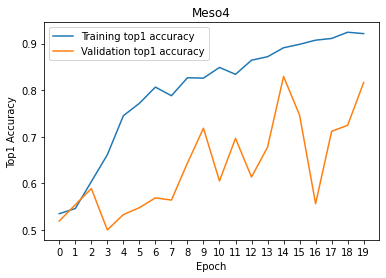

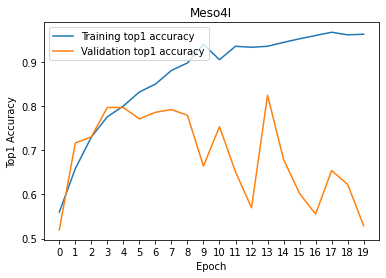

In [ ]:
# visualize the training / validation accuracies

x = np.arange(num_epochs)


# plt.plot(x, tr_his)
# plt.plot(x, val_his)
# plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
# plt.xticks(x)
# plt.xlabel('Epoch')
# plt.ylabel('Top1 Accuracy')
# plt.title('VGG')
# plt.show()

# plt.plot(x, tr_his_BN)
# plt.plot(x, val_his_BN)
# plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
# plt.xticks(x)
# plt.xlabel('Epoch')
# plt.ylabel('Top1 Accuracy')
# plt.title('MiniVGG-BN')
# plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, tr_his_meso)
plt.plot(x, val_his_meso)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Meso4')
plt.show()

plt.plot(x, tr_his_mesoI)
plt.plot(x, val_his_mesoI)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Meso4I')
plt.show()


In [ ]:
def test(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on test images: %d %%' % (
        100 * correct / total))

In [ ]:
##### To pass the test, both networks should have Top-5 accuracy above 55% #####
# uncomment these two lines to load pretrained weights
# vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
# # print(vgg_BN.eval()) 
print("vgg")
test(vgg, dataloaders['test'])
print("vgg-bn")
test(vgg_BN, dataloaders['test'])
print("meso")
test(meso, dataloaders['test'])
print("meso-I")
test(mesoI, dataloaders['test'])



vgg
Accuracy of the network on test images: 67 %
vgg-bn
Accuracy of the network on test images: 82 %
meso
Accuracy of the network on test images: 80 %
meso-I
Accuracy of the network on test images: 54 %
